# Szanowni Państwo, jak co tydzień nowy notatnik. 
__Bardzo dziękuję Maciejowi Stanuchowi za pomoć w przygotowaniu tego notatnika.__

Na początek biblioteki:

In [13]:
import numpy as np
import matplotlib.pylab as plt
from skimage import color, morphology
from scipy import signal
import scipy
%matplotlib inline

Wczytanie obrazu oraz konwersja na skalę szarości (8bit)

In [14]:
im = plt.imread('Xray-300x247.jpg')
im.shape
im_gray = color.rgb2gray(im)

Definujemy funkcję do binaryzacji obrazu na podstawie zadanego progu. Funkcja będzie nam potrzebna do konwersji obrazu w skali szarości na obraz binarny. Jest to najprostsza metoda segmentacji obrazu. W wersji podstawowej, określenie co jest obiektem na obrazie, a co nie bazuje na porównaniu wartości pikseli/wokseli z zadanym progiem.
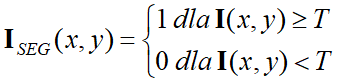
Oczywiście znak nierówności może być skierowany w drugą stronę. Bedzie to zależało od tego czy nasz obiekt w obrazie ma przypisane małe czy duże wartości:

In [15]:
def getBinaryImage(img, threshold, mode='upper'):
    if mode == 'upper':
        return im_gray > threshold
    elif mode == 'lower':
        return im_gray < threshold
    else:
        raise Exception("Mode not supported")

Przykładowo wywołajmy funkcję z wartością progu równą średniej z obrazu:

In [16]:
im_binary = getBinaryImage(im_gray, np.mean(im_gray))

Dla ułatwienia tworzymy funkcję, która pomoże nam porównywać obrazy, które wytworzymy:

In [17]:
def compareImages(img1, img2):
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(img1, cmap='gray')
    plt.title('original')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap='gray')
    plt.title('processed')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    if (img1.dtype == bool and img2.dtype == bool):
        plt.imshow(np.asarray(img2, dtype=np.uint16) - np.asarray(img1, dtype=np.uint16), cmap='gray')
    else:
        plt.imshow(img2 - img1, cmap='gray')
    plt.title('difference')
    plt.axis('off')

Zobaczmy jaki efekt wywołała binaryzacja:

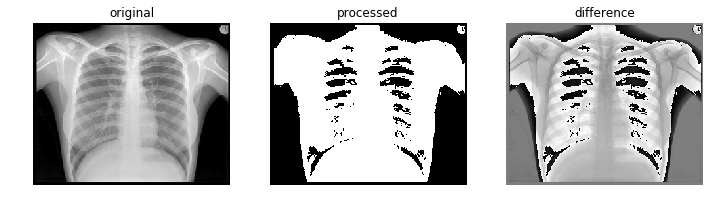

In [18]:
compareImages(im_gray, im_binary)

Jak pewnie już Państwo wiecie, w przypadku operacji morfologicznych konieczne jest zdefiniowanie elementu strukturalnego. W związku z tym tworzymy funkcje, które pomogą nam wygenerować element strukturalny __SE__ o zadanych parametrach (rozpatrujemy dwa typy elementów, dysk oraz kwadrat):

In [19]:
def isInCircle(x, y, center_x, center_y, radius):
    out = (x - center_x)**2 + (y - center_y)**2 < radius**2
    return out

def createDisk(radius, SE):
    disk = np.zeros_like(SE)
    x_SE, y_SE = np.shape(SE)
    x_center = int(np.floor(x_SE / 2))
    y_center = int(np.floor(y_SE / 2))
    for i in range(0,np.shape(SE)[0]):
        for j in range(0, np.shape(SE)[1]):
            disk[i,j] = isInCircle(i, j, x_center, y_center, radius + 0.2)
    return disk

def createSE(size = (3,3), shape='filled', radius = -1):
    SE = np.ones(size, np.uint8)
    if shape == 'filled':
        return SE
    elif shape == 'disk':
        if radius == -1:
            radius = int(np.floor(np.max(np.shape(SE)) / 2))
        return createDisk(radius, SE)

Jedną z dwóch najprostszych, podstawowych operacji morfologicznych jest dylatacja morfologiczna. Możemy ją zdefiniować jako filtr maksymalny liczony z  sąsiedztwa definiowanego elementem strukturalnym.
__Implementacja__:
W celu wyznaczenia dylatacji obrazu bez użycia bibliotek potrzebujemy zdefiniować funkcję, którą wykorzystamy do pobrania sąsiedztwa danego piksela (getImageSubset) z uwzględnieniem wartości brzegowych (tam, gdzie wcyhodzimy poza zakres to uzupełniamy zerami). Dla wartości zerowych, dla elementu strukturalnego, również zerujemy ostateczną wartość danego piksela. Kolejnym krokiem jest znalezienie maksimum z tak dobranego sąsiedztwa piksela i wpisanie go do nowej macierzy. W rezultacie otrzymujemy dylatację z wykorzystaniem elementu strukturalnego.

In [20]:
def getImageSubset(img, i, j, SE, x_SE, y_SE):
    subset = []
    lowerBound_X = i - int(np.floor(x_SE / 2))
    upperBound_X = i + int(np.floor(x_SE / 2))
    lowerBound_Y = j - int(np.floor(y_SE / 2))
    upperBound_Y = j + int(np.floor(y_SE / 2))
    x_max, y_max = np.shape(img)
    for se_x, k in enumerate(range(lowerBound_X, upperBound_X+1)):
        for se_y, l in enumerate(range(lowerBound_Y, upperBound_Y+1)):
            if k < 0 or l < 0 or k > x_max or l > y_max:
                subset.append(0)
            elif k < x_max and l < y_max:
                subset.append(img[k,l] * SE[se_x - 1, se_y - 1])
    return subset

def dilateManually(img, SE = np.ones((3,3), np.uint8)):
    x_SE, y_SE = np.shape(SE)
    x, y = np.shape(img)
    img_dilate = np.zeros_like(img)
    for i in range(0, x - 1):
        for j in range(0, y - 1):
            img_dilate[i,j] = np.max(getImageSubset(img, i, j, SE, x_SE, y_SE))
    return img_dilate

W następnym kroku generujemy przykładowy element strukturalny i wykorzystujemy go do porównania działania funkcji bibliotecznej ```(skimage.morphology.dilatation)```, do napisanej własnoręcznie funkcji.

In [21]:
SE = createSE(size = (5,5))

__Co istotne: dylatację możemy wykonać zarówno dla obrazów w skali szarości jak i obrazów binarnych__

In [22]:
im_dilate_function = dilateManually(im_gray, SE)
im_dilate_lib = morphology.dilation(im_gray,SE)

In [23]:
im_binary_dilate_function = dilateManually(im_binary, SE)
im_binary_dilate_lib = morphology.dilation(im_binary,SE)

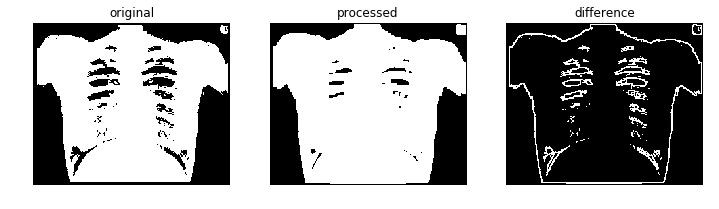

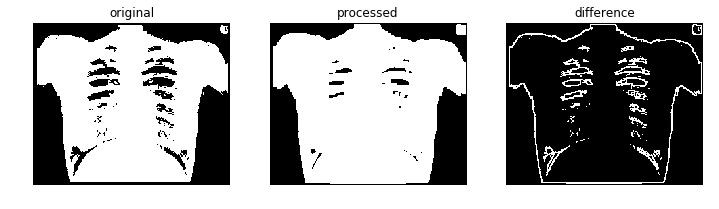

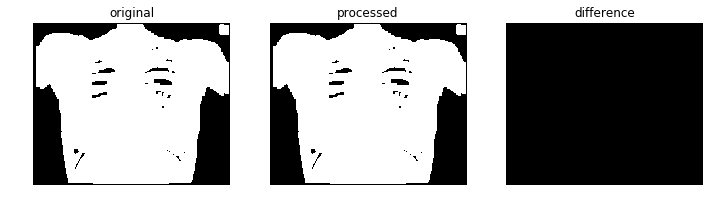

In [24]:
compareImages(im_binary, im_binary_dilate_function)
compareImages(im_binary, im_binary_dilate_lib)
compareImages(im_binary_dilate_function, im_binary_dilate_lib)

__A teraz czas na Państwa. Zachęcam do eksperymentowania i wykonania zadań. Oczywiście jak co tydzień jedno zadanie będzie oceniane na punkty.__